Lưu ý: Để train với GPU, chọn Runtime --> Change runtime type --> GPU

## Bước 1: Kết nối với Google Drive

Chọn mail có thư mục BreastDataset, copy link dán vào textbox


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Di chuyển đến folder chứa thư mục BreastDataset

In [ ]:
%cd /content/drive/MyDrive
!ls

/content/drive/MyDrive
 18110251_LeNguyenGiaBao_BTT3.rar
 1.png
 accuracy.png
 BreastDataset
 breast_dataset_VGG16.h5
 breast_VGG16_2.h5
 breast_VGG16_3.h5
 breast_VGG16.h5
 Classroom
'Colab Notebooks'
 LapTrinhWindow_DoAn01_BaiGiuXe_Nhom13
 loss.png
 Screenshot_2021-01-28-02-34-35-86_1c99860bf4b61b843a1056471ba010e4.png
 Video_2020-04-23_130000.mp4
 Web


## Bước 2: Import thư viện

In [ ]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2

## Bước 3: Xử lý dữ liệu


Khai báo đường dẫn thư mục dataset

In [ ]:
dataset_paths = glob.glob("/content/drive/MyDrive/BreastDataset/**/*.tif")

In [ ]:
X=[]
labels=[]
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2] # lấy tên folder chứa ảnh làm label
  label = classes.index(label)
  labels.append(label)

  img = cv2.imread(image_path)  
  img = cv2.resize(img, (300, 300))   
  image = np.array(img)
  X.append(image)

X = np.array(X,dtype="float16")
labels = np.array(labels)

y = to_categorical(labels)

Chia dữ liệu thành 3 tập: train, val, test

In [ ]:
(train_val_X, test_X, train_val_Y, test_Y) = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
(train_X, val_X, train_Y, val_Y) = train_test_split(train_val_X, train_val_Y, test_size=0.10, random_state=42)

## Bước 4: Chuẩn bị model VGG16 và các thông số config liên quan

Tạo biến ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

Định nghĩa hàm tạo model

In [ ]:
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    vgg_model = VGG16(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(300, 300, 3)))

    ann_model = vgg_model.output
    ann_model = MaxPooling2D(pool_size=(3, 3))(ann_model)
    ann_model = Flatten(name="flatten")(ann_model)
    ann_model = Dense(128, activation="relu")(ann_model)
    ann_model = Dropout(0.5)(ann_model)
    ann_model = Dense(output_shape, activation="softmax")(ann_model)
    
    model = Model(inputs=vgg_model.input, outputs=ann_model)
    
    if training:
        for layer in vgg_model.layers:
            layer.trainable = True
            
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

Khởi tạo các giá trị config

In [ ]:
INIT_LR = 1e-4
BATCH_SIZE = 64

EPOCHS = 50

Tạo biến checkpoint

In [ ]:
my_checkpointer = ModelCheckpoint(filepath="breast_dataset_VGG16_weight.h5", verbose=1, save_weights_only=True)

Khởi tạo model VGG16

In [ ]:
model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

Kiến trúc của Model

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

## Bước 5: Train model VGG16

Epoch: 50

Batch_size = 64

In [ ]:
result = model.fit(image_gen.flow(train_X, train_Y, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(train_X) // BATCH_SIZE, 
                   validation_data=(val_X, val_Y), 
                   validation_steps=len(val_X) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/50
20/20 [==============================] - 38s 2s/step - loss: 7.5893 - accuracy: 0.2383 - val_loss: 1.4064 - val_accuracy: 0.2671

Epoch 00001: saving model to breast_dataset_VGG16_weight.h5
Epoch 2/50
20/20 [==============================] - 36s 2s/step - loss: 1.3987 - accuracy: 0.2791 - val_loss: 1.3671 - val_accuracy: 0.3082

Epoch 00002: saving model to breast_dataset_VGG16_weight.h5
Epoch 3/50
20/20 [==============================] - 36s 2s/step - loss: 1.3895 - accuracy: 0.2797 - val_loss: 1.3635 - val_accuracy: 0.2877

Epoch 00003: saving model to breast_dataset_VGG16_weight.h5
Epoch 4/50
20/20 [==============================] - 36s 2s/step - loss: 1.3709 - accuracy: 0.3048 - val_loss: 1.3126 - val_accuracy: 0.3973

Epoch 00004: saving model to breast_dataset_VGG16_weight.h5
Epoch 5/50
20/20 [==============================] - 36s 2s/step - loss: 1.3363 - accuracy: 0.3528 - val_loss: 1.2793 - val_accuracy: 0.4041

Epoch 00005: saving model to breast_dataset_VGG16_weigh

Biểu đồ Accuracy

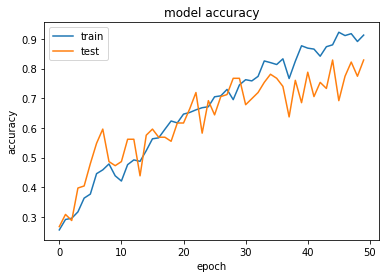

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

Biểu đồ Loss

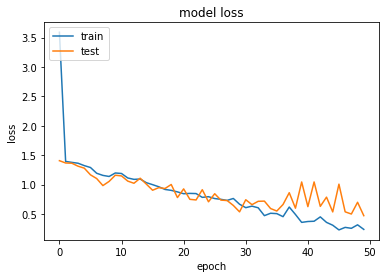

In [ ]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

## Bước 6: Thực nghiệm với tập test

In [ ]:
count = 0
for i in range(len(test_X)):
  x_test = test_X[i]
  x_test = np.expand_dims(x_test, axis=0)

  y_test = test_Y[i]
  y_predict = np.argmax(model.predict(x_test))
  y_test = np.argmax(y_test)
  if y_test != y_predict:
    # print(y_test, y_predict)
    count +=1
print('Sai: ', count,'/', len(test_X))

Sai:  36 / 163
